## Sentiment Analysis 

### Using the IMDb review dataset to train a model for sentiment analysis

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

2025-03-25 06:18:19.554573: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 06:18:19.559448: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-25 06:18:19.573535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742879899.597580    9512 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742879899.604546    9512 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742879899.623393    9512 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [3]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

2025-03-25 06:18:23.542413: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
from src.review_learn import create_train_test_val, load_glove_embeddings

In [5]:
train_set, test_set, val_set = create_train_test_val(datasets, validation_fraction=0.2)

In [6]:
from src.review_stats import print_stats_of_texts, print_text_stats, TextStatisticUtils

In [7]:
train_set

<_TakeDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
from src.lookup_table_creator import LookupTableCreator

In [15]:
#table_creator = LookupTableCreator()

In [16]:
import json
#load lookup table from json
with open("lookup_table.json", "r") as file:
    loaded_dict = json.load(file)
#make string keys to byte strings
lookup_dict_bytes = {key.encode("utf-8"): value for key, value in loaded_dict.items()}

vocabs = tf.constant(list(lookup_dict_bytes.keys()))
values = tf.constant(list(lookup_dict_bytes.values()), dtype= tf.int64)

init = tf.lookup.KeyValueTensorInitializer(vocabs, values)
table = tf.lookup.StaticVocabularyTable(init, num_oov_buckets=1000)

In [17]:
#table = table_creator.create_lookup_table(train_set, 10000, 1000, 32)

In [18]:
#import json 
#lookup_dict = {word.decode('utf-8'): int(value.numpy()) for word, value in zip(table_creator.get_words().numpy(), table_creator.get_word_ids())}
#with open('lookup_table.json', "w") as file:
#    json.dump(lookup_dict, file)

In [19]:
from src.text_preprocessing import ReviewPreprocessor

In [20]:
preprocessor = ReviewPreprocessor(10000, 1000, table, batch_size=32, maxlen=200)

In [21]:
#embeddings = load_glove_embeddings('embeddings/glove.6B.100d.txt', tf.keras.datasets.imdb.get_word_index(), vocab_size=10000, embed_size=128, num_oov_buckets=1000)

In [22]:
train_data, test_data, validation_data = preprocessor.prepare_data_set(train_set), preprocessor.prepare_data_set(test_set), preprocessor.prepare_data_set(val_set)

In [23]:
reviewStats = TextStatisticUtils(train_set=train_set, test_set=test_set, val_set=val_set)

In [24]:
reviewStats.print_all_text_stats()

2025-03-25 06:20:02.492876: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-03-25 06:20:08.445624: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Statistics of Train Data: 
    | Average text length: 1323.40815 
    | Median text length: 977.0
    | Minimum text length: 64
    | Maximum text length: 13704
     


2025-03-25 06:20:15.732289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Statistics of Test Data: 
    | Average text length: 1293.7924 
    | Median text length: 962.0
    | Minimum text length: 32
    | Maximum text length: 12988
     
Statistics of Validation Data: 
    | Average text length: 1331.7156 
    | Median text length: 986.5
    | Minimum text length: 52
    | Maximum text length: 7731
     


In [26]:
#reviewStats.draw_class_dists()

In [27]:
for x_batch, y_batch in train_data.take(1):
    print(f"{x_batch.shape}")

(32, 200)


In [28]:
# Attention Layer Definition
class Attention(tf.keras.layers.Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        # Energie-Werte berechnen (Dot-Produkt der Inputs mit sich selbst)
        score = tf.matmul(inputs, inputs, transpose_b=True)
        
        # Softmax über die Scores zur Normalisierung
        attention_weights = tf.nn.softmax(score, axis=-1)
        
        # Kontextvektor als gewichtete Summe der Eingaben
        context_vector = tf.matmul(attention_weights, inputs)
        
        return context_vector

In [29]:
from tensorflow.keras.regularizers import l2


def build_model(n_hidden=2, embed_size=128, vocab_size=10000, num_oov_buckets=1000, dropout_rate=0.3, embedding_matrix=None):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(input_dim=vocab_size + num_oov_buckets, output_dim=embed_size))
    # 1D Convolutional Layer (Extrahiert lokale Merkmale)
    model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation="relu", padding="same"))
    ##model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    for hidden in range(n_hidden):
        model.add(
            tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=dropout_rate)))
    #model.add(tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)))
    
    # Attention Layer
    model.add(Attention())
    model.add(tf.keras.layers.GlobalAveragePooling1D())
    
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)))
    #model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.00025),
                  metrics=["accuracy"])
    return model

In [30]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)

In [31]:
model = build_model(n_hidden=1, vocab_size=10000, num_oov_buckets=1000, embed_size=128, dropout_rate=0.6)

In [32]:
history = model.fit(train_data, validation_data=validation_data, epochs=15, callbacks=[tf.keras.callbacks.ModelCheckpoint('sentiment_model.keras', save_best_only=True), 
                                                                                      tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                                                                                lr_scheduler])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 108s 163ms/step - accuracy: 0.5649 - loss: 1.1876 - val_accuracy: 0.8444 - val_loss: 0.3952 - learning_rate: 2.5000e-04
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.8568 - loss: 0.3705 - val_accuracy: 0.8636 - val_loss: 0.3367 - learning_rate: 2.5000e-04
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.9027 - loss: 0.2599 - val_accuracy: 0.8628 - val_loss: 0.3478 - learning_rate: 2.5000e-04
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.9276 - loss: 0.2004 - val_accuracy: 0.8570 - val_loss: 0.3691 - learning_rate: 2.5000e-04
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 164ms/step - accuracy: 0.9493 - loss: 0.1490 - val_accuracy: 0.8578 - val_loss: 0.4116 - learning_rate: 1.2500e-04
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 101s 161ms/step - accuracy: 0.9621 - loss: 0.1160 - val_accuracy: 0.8540 - val_loss: 0.4506 - learning_rate: 1.2500e-04
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
import matplotlib.pyplot as plt

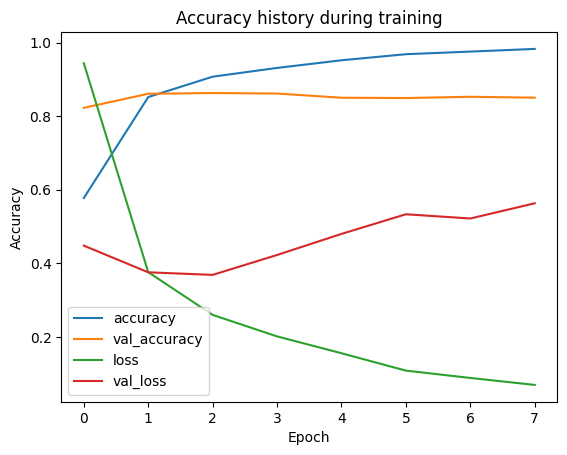

In [40]:
accuracy, val_accuracy, loss, val_loss = history.history["accuracy"], history.history["val_accuracy"], history.history["loss"], history.history["val_loss"]
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy history during training')
plt.show()

In [41]:
model.evaluate(test_data)    

782/782 ━━━━━━━━━━━━━━━━━━━━ 31s 40ms/step - accuracy: 0.8440 - loss: 0.4036


[0.4003904163837433, 0.8429999947547913]

## 